In [1]:
#from gcca import GCCA
import logging
# set log level
logging.root.setLevel(level=logging.INFO)
import numpy as np
from scipy import linalg,stats
from scipy.sparse.linalg import svds
# from sklearn.decomposition import TruncatedSVD
import glob
from tqdm import tqdm
from sklearn.preprocessing import normalize

from pathlib import Path
import re
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## See https://github.com/rupy/GCCA

from sklearn.cross_decomposition import CCA

import graspy
from graspy.plot import pairplot
%matplotlib inline

import seaborn as sns

np.set_printoptions(precision=5)

## Load Data

In [2]:
basedir = Path('..')
datadir = basedir / 'data' / 'raw'
correlation_dir = basedir / 'data' / 'interim' / 'latents'

In [3]:
## Grab filenames
def get_files(level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)'):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}\.csv'
    for f in os.listdir(datadir):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [4]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

#for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):
#    paths = get_files(level=level, task=task)

paths = get_files(level=levels[0], task=tasks[2])[:2]

In [5]:
data = []
subjs = []
for path,subj in paths[:2]:
    data.append(pd.read_csv(datadir / path, header = None).to_numpy())
    subjs.append(subj)

## GCCA

In [6]:
def _preprocess(x):
    # Mean along rows using sample mean and sample std
    x2 = stats.zscore(x,axis=1,ddof=1) 
    # Mean along columns
    mu = np.mean(x2,axis=0)
    x2 -= mu
    return(x2)

def gcca_meta(data, rank_tolerance=None, n_components=None):
    n = data[0].shape[0]
    
    metadata = []

    data = [_preprocess(x) for x in data]
    
    Uall = []
    Sall = []
    Vall = []
    ranks = []
    
    for x in tqdm(data):
        temp = {}
        # Preprocess
        x[np.isnan(x)] = 0
        
        temp['X'] = x

        # compute the SVD of the data
        #v,s,ut = linalg.svd(x.T, full_matrices=False)
        u,s,vt = linalg.svd(x, full_matrices=False)
        v = vt.T; ut = u.T
        temp['S'] = s; temp['V'] = v

        Sall.append(s)
        Vall.append(v)
        # Dimensions to reduce to
        if rank_tolerance:
            rank = sum(s > rank_tolerance)
        else:
            rank = n_components
            
        temp['rank']=rank
        ranks.append(rank)
        u = ut.T[:,:rank]
        Uall.append(u)
        temp['U'] = u
        
        metadata.append(temp); temp=None
        
    d = min(ranks)

    # Create a concatenated view of Us
    Uall_c = np.concatenate(Uall,axis=1)

    _,_,VV=svds(Uall_c,d)
    VV = np.flip(VV.T,axis=1)
    VV = VV[:,:min([d,VV.shape[1]])]

    # SVDS the concatenated Us
    idx_end = 0
    projX = []
    for i in range(len(data)):
        idx_start = idx_end
        idx_end = idx_start + ranks[i]
        VVi = normalize(VV[idx_start:idx_end,:],'l2',axis=0)
        metadata[i]['VVi']=VVi
        # Compute the canonical projections
        A = np.sqrt(n-1) * Vall[i][:,:ranks[i]]
        metadata[i]['inv'] = linalg.solve(np.diag(Sall[i][:ranks[i]]), VVi)
        A = A @ metadata[i]['inv']
        projX.append(data[i] @ A)
        
        metadata[i]['A'] = A
        metadata[i]['projX'] = projX[-1]
        
    return(projX, metadata, Uall_c, VV)

def gcca(data, rank_tolerance=None, n_components=None, tall=False):
    n = data[0].shape[0]

    data = [_preprocess(x) for x in data]
    
    Uall = []
    Sall = []
    Vall = []
    ranks = []
    
    for x in tqdm(data):
        # Preprocess
        x[np.isnan(x)] = 0

        # compute the SVD of the data
        if tall:
            v,s,ut = linalg.svd(x.T, full_matrices=False)
        else:
            u,s,vt = linalg.svd(x, full_matrices=False)
            ut = u.T; v = vt.T
        
        Sall.append(s)
        Vall.append(v)
        # Dimensions to reduce to
        if rank_tolerance:
            rank = sum(s > rank_tolerance)
        else:
            rank = n_components
        ranks.append(rank)
        u = ut.T[:,:rank]
        Uall.append(u)

    d = min(ranks)

    # Create a concatenated view of Us
    Uall_c = np.concatenate(Uall,axis=1)

    _,_,VV=svds(Uall_c,d)
    VV = np.flip(VV.T,axis=1)
    VV = VV[:,:min([d,VV.shape[1]])]

    # SVDS the concatenated Us
    idx_end = 0
    projX = []
    for i in range(len(data)):
        idx_start = idx_end
        idx_end = idx_start + ranks[i]
        VVi = normalize(VV[idx_start:idx_end,:],'l2',axis=0)
        # Compute the canonical projections
        A = np.sqrt(n-1) * Vall[i][:,:ranks[i]]
        A = A @ (linalg.solve(np.diag(Sall[i][:ranks[i]]), VVi))
        projX.append(data[i] @ A)
        
    return(projX,ranks)

## GCCA Rupy Implementation

In [8]:
import numpy as np
from scipy.linalg import eig
import logging
import os
import matplotlib.pyplot as plt
import math
from matplotlib import colors
import h5py

class GCCA:

    def __init__(self, n_components=2, reg_param=0.1):

        # log setting
        program = os.path.basename(__name__)
        self.logger = logging.getLogger(program)
        logging.basicConfig(format='%(asctime)s : %(name)s : %(levelname)s : %(message)s')

        # GCCA params
        self.n_components = n_components
        self.reg_param = reg_param

        # result of fitting
        self.data_num = 0
        self.cov_mat = [[]]
        self.h_list = []
        self.eigvals = np.array([])

        # result of transformation
        self.z_list = []

    def eigvec_normalization(self, eig_vecs, x_var):
        self.logger.info("normalization")
        z_var = np.dot(eig_vecs.T, np.dot(x_var, eig_vecs))
        invvar = np.diag(np.reciprocal(np.sqrt(np.diag(z_var))))
        eig_vecs = np.dot(eig_vecs, invvar)
        # print np.dot(eig_vecs.T, np.dot(x_var, eig_vecs)).round().astype(int)
        return eig_vecs


    def solve_eigprob(self, left, right):

        self.logger.info("calculating eigen dimension")
        eig_dim = min([np.linalg.matrix_rank(left), np.linalg.matrix_rank(right)])

        self.logger.info("calculating eigenvalues & eigenvector")
        eig_vals, eig_vecs = eig(left, right)

        self.logger.info("sorting eigenvalues & eigenvector")
        sort_indices = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sort_indices][:eig_dim].real
        eig_vecs = eig_vecs[:,sort_indices][:,:eig_dim].real

        return eig_vals, eig_vecs

    def calc_cov_mat(self, x_list):

        data_num = len(x_list)

        self.logger.info("calc variance & covariance matrix")
        z = np.vstack([x.T for x in x_list])
        cov = np.cov(z)
        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = [[np.array([]) for col in range(data_num)] for row in range(data_num)]
        for i in range(data_num):
            for j in range(data_num):
                i_start, i_end = d_list[i], d_list[i + 1]
                j_start, j_end = d_list[j], d_list[j + 1]
                cov_mat[i][j] = cov[i_start:i_end, j_start:j_end]

        return cov_mat

    def add_regularization_term(self, cov_mat):

        data_num = len(cov_mat)

        # regularization
        self.logger.info("adding regularization term")
        for i in range(data_num):
            cov_mat[i][i] += self.reg_param * np.average(np.diag(cov_mat[i][i])) * np.eye(cov_mat[i][i].shape[0])

        return cov_mat

    def fit(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = self.calc_cov_mat(x_norm_list)
        cov_mat = self.add_regularization_term(cov_mat)

        self.logger.info("calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )")
        # left = A, right = B
        left = 0.5 * np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i == j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )
        right = np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i != j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )

        # calc GEV
        self.logger.info("solving")
        eigvals, eigvecs = self.solve_eigprob(left, right)

        h_list = [eigvecs[start:end] for start, end in zip(d_list[0:-1], d_list[1:])]
        h_list_norm = [self.eigvec_normalization(h, cov_mat[i][i]) for i, h in enumerate(h_list)]

        # substitute local variables for member variables
        self.data_num = data_num
        self.cov_mat = cov_mat
        self.h_list = h_list_norm
        self.eigvals = eigvals

    def transform(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        if self.data_num != data_num:
            raise Exception('data num when fitting is different from data num to be transformed')

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        self.logger.info("transform matrices by GCCA")
        z_list = [np.dot(x, h_vec) for x, h_vec in zip(x_norm_list, self.h_list)]

        self.z_list = z_list

        return z_list

    def fit_transform(self, *x_list):
        self.fit(x_list)
        self.transform(x_list)

    @staticmethod
    def normalize(mat):
        m = np.mean(mat, axis=0)
        mat = mat - m
        return mat

    def save_params(self, filepath):

        self.logger.info("saving to %s", filepath)
        with h5py.File(filepath, 'w') as f:
            f.create_dataset("n_components", data=self.n_components)
            f.create_dataset("reg_param", data=self.reg_param)
            f.create_dataset("data_num", data=self.data_num)

            cov_grp = f.create_group("cov_mat")
            for i, row in enumerate(self.cov_mat):
                for j, cov in enumerate(row):
                    cov_grp.create_dataset(str(i) + "_" + str(j), data=cov)

            h_grp = f.create_group("h_list")
            for i, h in enumerate(self.h_list):
                h_grp.create_dataset(str(i), data=h)

            f.create_dataset("eig_vals", data=self.eigvals)

            if len(self.z_list) != 0:
                z_grp = f.create_group("z_list")
                for i, z in enumerate(self.z_list):
                    z_grp.create_dataset(str(i), data=z)
            f.flush()

    def load_params(self, filepath):
        self.logger.info("loading from %s", filepath)
        with h5py.File(filepath, "r") as f:
            self.n_components = f["n_components"].value
            self.reg_param = f["reg_param"].value
            self.data_num = f["data_num"].value

            self.cov_mat = [[np.array([]) for col in range(self.data_num)] for row in range(self.data_num)]
            for i in range(self.data_num):
                for j in range(self.data_num):
                    self.cov_mat[i][j] = f["cov_mat/" + str(i) + "_" + str(j)]
            self.h_list = [None] * self.data_num
            for i in range(self.data_num):
                self.h_list[i] = f["h_list/" + str(i)].value
            self.eig_vals = f["eig_vals"].value

            if "z_list" in f:
                self.z_list = [None] * self.data_num
                for i in range(self.data_num):
                    self.z_list[i] = f["z_list/" + str(i)].value
            f.flush()

    def plot_result(self):

        self.logger.info("plotting result")
        col_num = int(math.ceil(math.sqrt(self.data_num + 1)))
        row_num = int((self.data_num + 1) / float(col_num))
        if row_num != (self.data_num + 1) / float(col_num):
            row_num += 1

        # begin plot
        plt.figure()

        color_list = colors.cnames.keys()
        for i in range(self.data_num):

            plt.subplot(row_num, col_num, i + 1)
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_%d(GCCA)" % (i + 1))

        plt.subplot(row_num, col_num, self.data_num + 1)
        for i in range(self.data_num):
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_ALL(GCCA)")

        plt.show()

    def calc_correlations(self):
        for i, z_i in enumerate(self.z_list):
            for j, z_j in enumerate(self.z_list):
                if i < j:
                   print("(%d, %d): %f" % (i, j, np.corrcoef(z_i[:,0], z_j[:,0])[0, 1]))

In [19]:
gcca = GCCA(n_components=4, reg_param=0)
gcca.fit(data[0], data[1])
projs2 = gcca.transform(data[0], data[1])

2019-07-25 06:06:51,188 : __main__ : INFO : data num is 2
2019-07-25 06:06:51,192 : __main__ : INFO : data shape x_0: (18715, 300)
2019-07-25 06:06:51,195 : __main__ : INFO : data shape x_1: (18715, 300)
2019-07-25 06:06:51,196 : __main__ : INFO : normalizing
2019-07-25 06:06:51,350 : __main__ : INFO : calc variance & covariance matrix
2019-07-25 06:06:51,801 : __main__ : INFO : adding regularization term
2019-07-25 06:06:51,803 : __main__ : INFO : calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )
2019-07-25 06:06:51,822 : __main__ : INFO : solving
2019-07-25 06:06:51,823 : __main__ : INFO : calculating eigen dimension
2019-07-25 06:06:52,047 : __main__ : INFO : calculating eigenvalues & eigenvector
2019-07-25 06:06:54,691 : __main__ : INFO : sorting eigenvalues & eigenvector
2019-07-25 06:06:54,694 : __main__ : INFO : normalization
2019-07-25 06:06:54,722 : __main__ : INFO : normalization
2019-07-25 06:06:54,771 : __main__ : INFO : data num is 2
2019-07-25 06:06:54,772

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


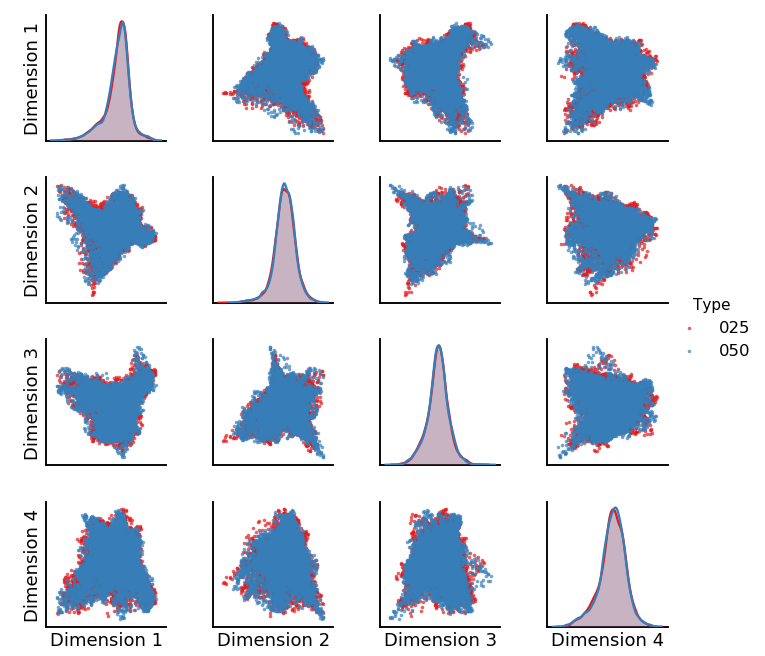

In [29]:
## Rupy Implementation
pairplot(np.vstack(projs2)[:,:4], labels=np.hstack((i*projs2[0].shape[0] for i in subjs)))

## CCA

In [13]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=4)
cca.fit(data[0],data[1])


X_c, Y_c = cca.transform(data[0],data[1])

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


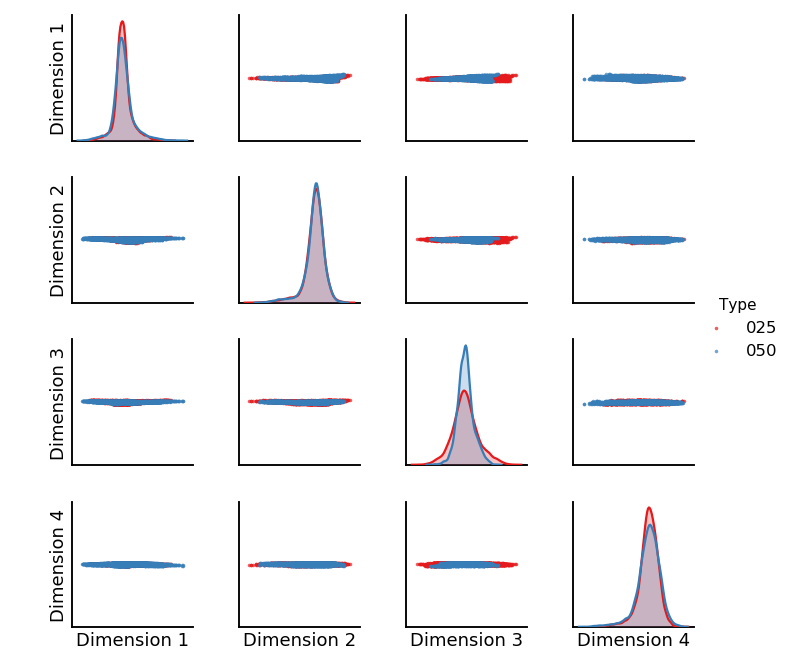

In [17]:
## My Python
pairplot(np.vstack((X_c,Y_c)), labels=np.hstack((i*len(Y_c) for i in subjs)))

## My GCCA

In [48]:
num_views = 2 # Number of subjects (views) to consider
rank_tolerance = 300

#projs, metadata, Uall_c, VV = gcca_meta(data=data, rank_tolerance=rank_tolerance)
projs,ranks = gcca(data=data, rank_tolerance=rank_tolerance, tall=True)

100%|██████████| 2/2 [00:06<00:00,  2.93s/it]


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


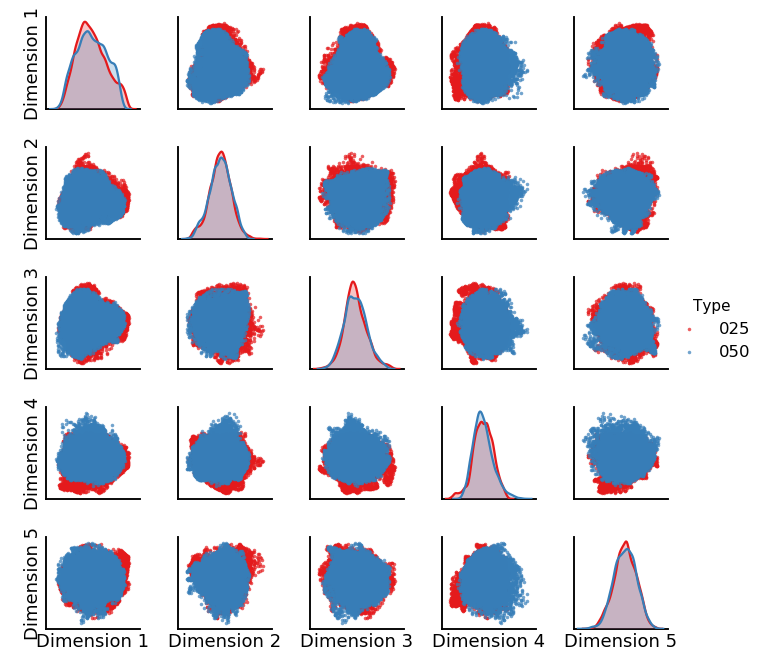

In [49]:
## My Python
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in subjs)), height=2)

### Load MATLAB GCCA results

In [21]:
pathsM = []
subjsM = []
for f in os.listdir(basedir / 'data'):
    if f[-3:] == 'csv' and 'thresh300' in f:
        pathsM.append(basedir / 'data' / f)
        subjsM.append('_'.join(f[:-4].split('_')[1:]))

In [23]:
projsM = []
for path in pathsM:
    print(path)
    projsM.append(pd.read_csv(path, header=None).to_numpy())

../data/matlab_compassion_025_thresh300.csv
../data/matlab_compassion_050_thresh300.csv


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


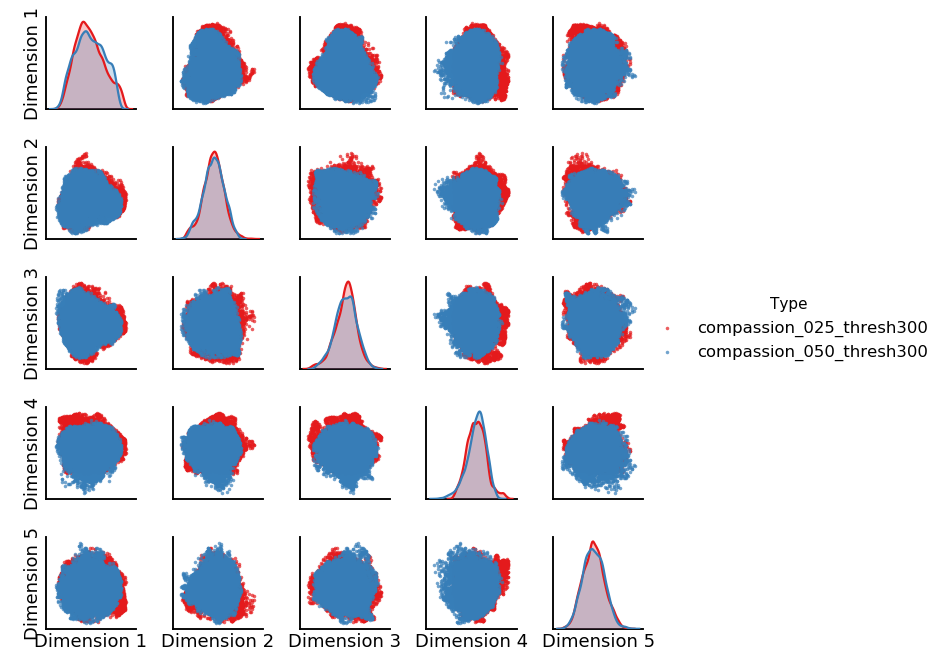

In [24]:
pairplot(np.vstack(projsM), labels=np.hstack(([i]*projsM[0].shape[0] for i in subjsM)), height=2)

## Compare MATLAB to Python

(array([ 3074.,  3057.,  3057.,  3085., 34240., 34574.,  3086.,  3178.,
         3180.,  3044.]),
 array([-4.99993e-05, -3.99998e-05, -3.00004e-05, -2.00009e-05,
        -1.00015e-05, -2.05450e-09,  9.99739e-06,  1.99968e-05,
         2.99963e-05,  3.99957e-05,  4.99952e-05]),
 <a list of 10 Patch objects>)

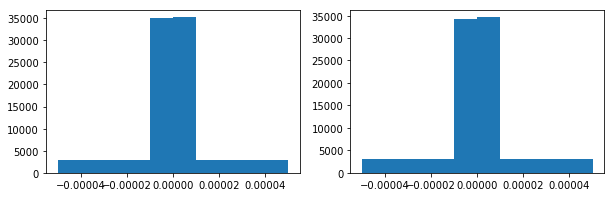

In [57]:
## Subtracted
transform = np.diag([1,1,-1,-1,-1])


plt.subplots(1,2,figsize=(10,3))
diff = [projsM[i] @ transform - projs[i] for i in [0,1]]
plt.subplot(1,2,1)
plt.hist(diff[0].flatten())
plt.subplot(1,2,2)
plt.hist(diff[1].flatten())

## Correctness Simulation Testing

In [590]:
#mus = [1,2,3,1,2,3]
mus = [1,2,3]
#var = [1,1,1,2,2,2]
n_features = 3
n_subjects = 3
test_data = np.zeros(shape=(n_subjects,len(mus),n_features))
for s in range(n_subjects):
    for i,mu in enumerate(mus):
        test_data[s,i,:] = [np.random.normal(mu+s*10, 1) for _ in range(n_features)]

In [530]:
print(test_data)

[[[ 0.18722 -0.03206  0.51329]
  [ 0.83759  2.18427  1.19634]
  [ 3.33906  2.62942  4.29433]]

 [[12.41595 11.67267 11.35671]
  [ 9.5984  11.7798  11.80744]
  [11.97393 13.7211  15.49403]]]


In [591]:
projs, metadata, Uall_c, VV = gcca(data=test_data, rank_tolerance=0.01)

100%|██████████| 3/3 [00:00<00:00, 464.30it/s]


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


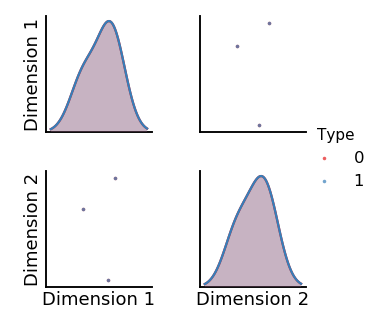

In [532]:
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in [[i] for i in range(n_subjects)])))

In [592]:
## Correlated Variables X=Y
X = np.array([[np.random.normal(1,1) for _ in range(5)] for _ in range(4)])
Y = np.array([[np.random.normal(0,1) for _ in range(5)] for _ in range(4)])
Z = np.array([[np.random.normal(-1,1) for _ in range(5)] for _ in range(4)])
projs, metadata, Uall_c, VV = gcca(data=[X,Y,Z], n_components=2)

100%|██████████| 3/3 [00:00<00:00, 2707.17it/s]


In [593]:
projs[0].shape

(4, 2)

In [602]:
idx = [0,1,2]
As = [metadata[i]['A'] for i in idx]
data = [X,Y,Z]
avg_inv_proj = np.mean(np.array([projs[i] @ linalg.pinv(As[i]) for i in range(len(projs))]),axis=0)
data2 = [data[i] - avg_inv_proj for i in idx]
#data2 = [data[i] - projs[i] for i in idx]

In [603]:
np.array([projs[i] @ linalg.pinv(As[i]) for i in idx])

array([[[-1.1353 ,  1.00387,  0.93699, -0.58134, -0.22421],
        [ 1.24817, -1.15421, -0.15936, -0.64202,  0.70741],
        [ 1.01661, -0.90737, -0.69345,  0.30637,  0.27783],
        [-1.12948,  1.05771, -0.08419,  0.91699, -0.76103]],

       [[-0.35553, -1.51922,  0.16564,  0.05529,  1.65382],
        [-0.20196, -0.35053, -0.05579,  0.86344, -0.25516],
        [ 0.21377,  0.79723, -0.0656 , -0.22196, -0.72344],
        [ 0.34372,  1.07252, -0.04425, -0.69676, -0.67522]],

       [[-0.52812,  0.29208,  0.41624, -0.85544,  0.67523],
        [ 0.19972,  0.07204,  0.18332, -0.00848, -0.4466 ],
        [ 0.31376,  0.08246,  0.23064,  0.04257, -0.66943],
        [ 0.01464, -0.44657, -0.83021,  0.82135,  0.44079]]])

In [579]:
i=0
projs[i] @ linalg.pinv(As[i])

array([[-1.38198,  0.30558,  1.2209 ,  0.84777, -0.99227],
       [ 1.37723, -0.74088, -0.75452,  0.67596, -0.55779],
       [ 0.27687,  0.15477, -0.47337, -0.92262,  0.96436],
       [-0.27212,  0.28054,  0.00699, -0.60111,  0.58571]])

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


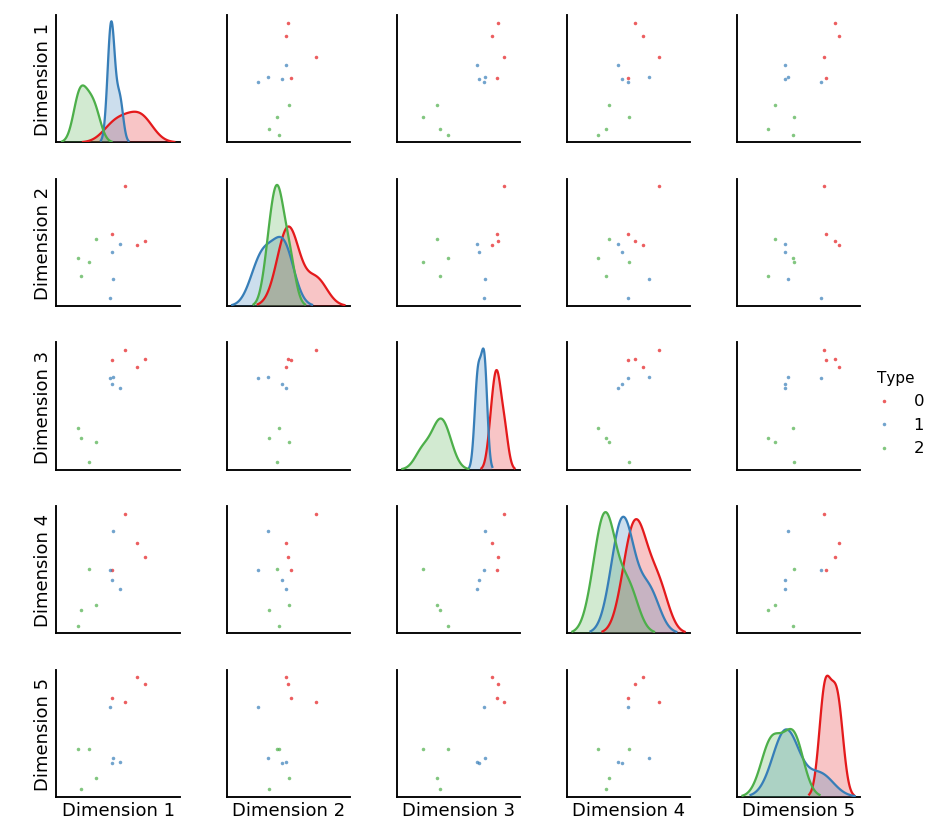

In [604]:
pairplot(np.vstack(data), labels=np.hstack((i*data2[0].shape[0] for i in [[i] for i in idx])))

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


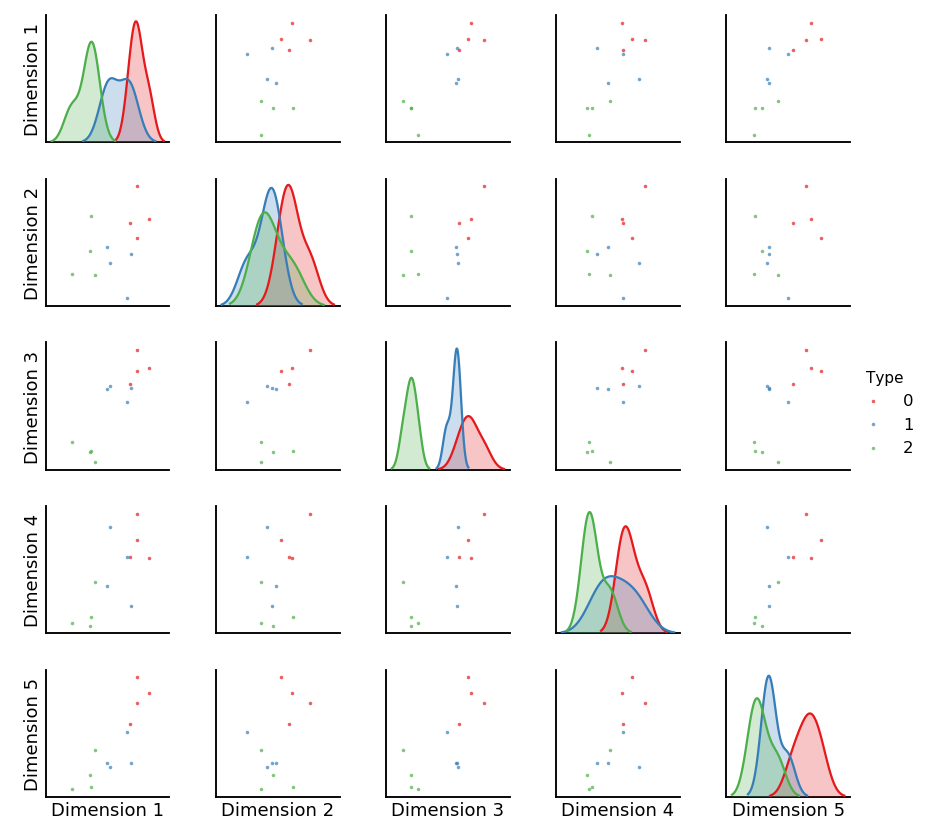

In [605]:
pairplot(np.vstack(data2), labels=np.hstack((i*data2[0].shape[0] for i in [[i] for i in idx])))

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


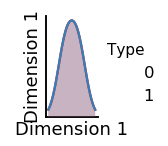

In [539]:
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in [[i] for i in range(2)])))

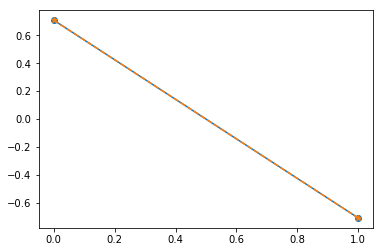

In [411]:
plt.plot(projs[0], '-o')
plt.plot(projs[1], '--*')

## Correctness Testing
Goal: show that the GCCA implementation correctly selected dimensions that when projected onto correlate perfectly
Structure:
1. Simualated datasets (X,Y)
    * n rows, (cx,cy) columns respectively
    * s signal dimensions (columns) with the same data in both x,y (correlates perfectly) with indices (ix,iy) respectively
2. Generate signal data
3. Generate noisy, uncorrelated observation matrices
4. Place signal data into (ix,iy) indices
5. Run GCCA and check that projections selected are (ix,iy), (consistency?)

In [214]:
def get_test_data(n):
    cx = 5; cy = 5
    s = 2; ix = (0,1); iy = (0,2)

    #X = np.zeros((n,cx))
    X = np.random.randn(n, cx)
    #Y = np.zeros((n,cy))
    Y = np.random.randn(n, cy)

    signals = np.random.randn(n,s)
    #signals = np.zeros((n,s))

    for i,(jx,jy) in enumerate(zip(ix,iy)):
        X[:,jx] = signals[:,i]
        Y[:,jy] = signals[:,i]
        
    return(X,Y)

In [222]:
linalg.norm(np.array([[0,1],[2,3]]), axis=0)

array([2.    , 3.1623])

In [296]:
true_idx = []
false_idx = []
ns = [10,25,50,100,200,500,1000,10000]
false_idx_avg = {i:[] for i in range(len(metadata))}
false_idx_std = {i:[] for i in range(len(metadata))}
ixs = [ix,iy]
for n in ns:
    _, metadata, _, _ = gcca(data=get_test_data(n), rank_tolerance=1)
    
    temp = metadata[0]['A'][ix,:] - metadata[1]['A'][iy,:]
    true_idx.append(temp.flatten()[:4])
    
    for j in range(len(metadata)):
        ixf = [i for i in range(metadata[j]['A'].shape[0]) if i not in ixs[j]]
        temp = linalg.norm(metadata[j]['A'][ixf,:], axis=0)
        false_idx_avg[j].append(np.mean(temp))
        false_idx_std[j].append(np.std(temp))
        
    ixf = [i for i in range(metadata[0]['A'].shape[0]) if i not in ixs[0]]
    iyf = [i for i in range(metadata[1]['A'].shape[0]) if i not in ixs[1]]
    temp = metadata[0]['A'][ixf,:] - metadata[1]['A'][iyf,:]
    false_idx.append(temp.flatten()[:4])

100%|██████████| 2/2 [00:00<00:00, 130.08it/s]


In [290]:
n = 10000
projs, metadata, _, _ = gcca(data=get_test_data(n), rank_tolerance=1)

100%|██████████| 2/2 [00:00<00:00, 364.98it/s]


In [291]:
metadata[0]['A']

array([[ 7.0947e-01,  5.3871e-01,  5.3358e-04, -3.5922e-03],
       [-7.0312e-01,  5.5770e-01,  5.2657e-03, -1.5028e-02],
       [-3.5854e-03, -3.6015e-01, -7.7908e-01,  2.7270e-01],
       [-8.8098e-04, -3.8006e-01,  1.5649e-01, -7.9104e-01],
       [-1.8886e-03, -3.5620e-01,  6.1679e-01,  5.3696e-01]])

In [292]:
metadata[1]['A']

array([[ 7.0789e-01,  5.3695e-01,  6.9927e-04,  8.2288e-03],
       [-2.0793e-03, -3.7402e-01, -5.4034e-01,  6.1133e-01],
       [-7.0461e-01,  5.5966e-01,  1.2834e-02,  7.8607e-03],
       [ 8.4415e-04, -3.7115e-01,  7.9777e-01,  1.4864e-01],
       [-2.0449e-03, -3.5144e-01, -2.7096e-01, -7.7606e-01]])

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


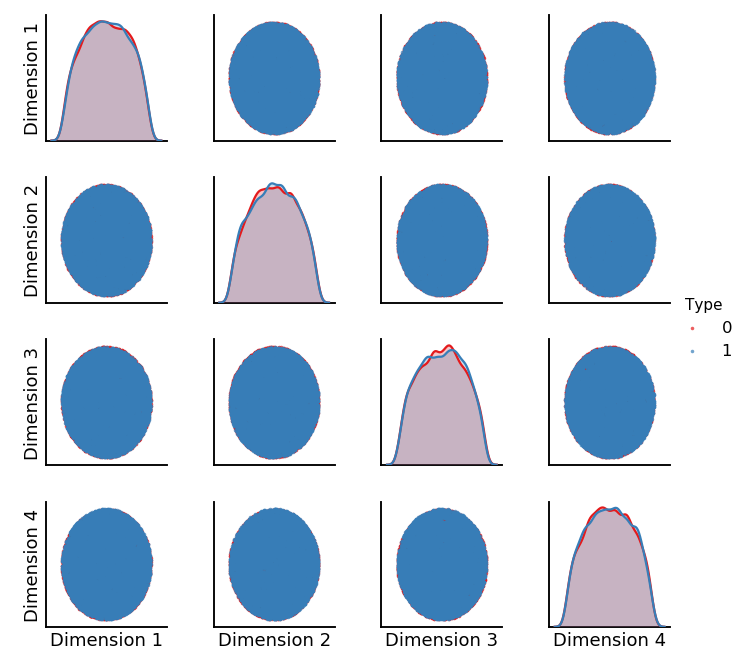

In [293]:
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in [[i] for i in range(2)])))

In [285]:
metadata[0]['A'][(2,3,4),:]

array([[ 3.5831e-04,  3.6991e-01, -4.7150e-01, -6.7159e-01],
       [-9.0544e-03,  3.6861e-01, -3.4041e-01,  7.2693e-01],
       [ 9.1963e-04,  3.6261e-01,  8.1731e-01, -6.5072e-02]])

In [286]:
metadata[1]['A'][(1,3,4),:]

array([[ 1.4332e-03,  3.7410e-01, -6.9800e-01,  4.3035e-01],
       [-4.5824e-04,  3.3432e-01,  7.1901e-01,  4.1197e-01],
       [-4.5012e-03,  3.8636e-01, -5.0674e-03, -8.0233e-01]])

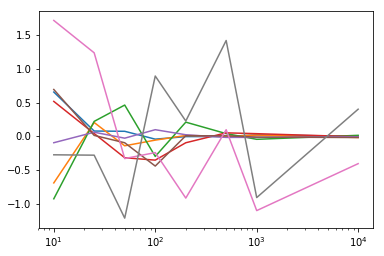

In [300]:
plt.plot(ns,true_idx)
plt.xscale('log')
plt.show()

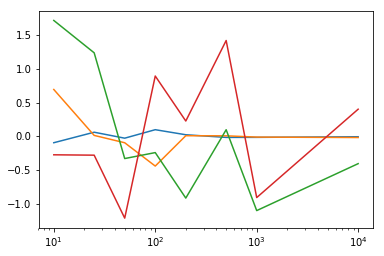

In [299]:
plt.plot(ns,false_idx)
plt.xscale('log')
plt.show()

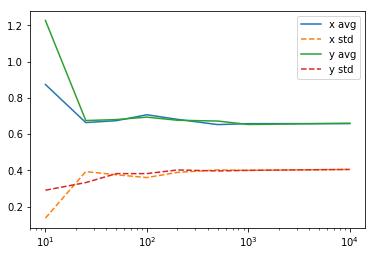

In [298]:
plt.figure()
labels = ['x','y']
for i in range(len(metadata)):
    plt.plot(ns,false_idx_avg[i],'-',label=f'{labels[i]} avg')
    plt.plot(ns,false_idx_std[i],'--',label=f'{labels[i]} std')
plt.legend()
plt.xscale('log')
plt.show()